In [1]:
import pandas
import datetime
import os
import numpy
from scipy import signal, ndimage
from davitpy.models import *
from davitpy import utils
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import Normalize
from matplotlib import ticker
import seaborn as sns
%matplotlib inline

In [2]:
selDT = datetime.datetime( 2011, 4, 9, 8, 40 )#datetime.datetime( 2011, 4, 9, 8, 40 )
medFiltedSize = ( 1, 3 )
fileDtStr = selDT.strftime("%y%m%d")
# Load the appropriate file based on date
baseDir = "../data/"
for root, dirs, files in os.walk(baseDir):
    for fName in files:
        if fName.find(fileDtStr) != -1:
            inpTecFile = root + "/" + fName

In [3]:
dataDF = pandas.read_hdf(inpTecFile, 'Data/Table Layout')
dataDF["date"] = pandas.to_datetime(dataDF["year"]*10000000000 +\
                                    dataDF["month"]*100000000 + dataDF["day"]*1000000 +\
                                    dataDF["hour"]*10000 + dataDF["min"]*100 +\
                                    dataDF["sec"],format='%Y%m%d%H%M%S')
# Only take selected datetime
dataDF["selTimeDel"] = dataDF["date"] - selDT
dataDF = dataDF[ dataDF["selTimeDel"] == min(abs(dataDF["selTimeDel"])) ].reset_index(drop=True)
# Discard tec values which are 2stds away!
cutOffLimit = dataDF["tec"].mean() + 2*dataDF["tec"].std()
dataDF = dataDF[ dataDF["tec"] <= cutOffLimit ]
dataDF = dataDF[ [ "date", "gdlat", "glon", "tec", "dtec" ] ]
dataDF.head()

,date,gdlat,glon,tec,dtec
0,2011-04-09 08:42:30,-90.0,-3.0,4.2,2.6
1,2011-04-09 08:42:30,-90.0,-2.0,4.4,2.6
2,2011-04-09 08:42:30,-90.0,-1.0,4.3,2.5
3,2011-04-09 08:42:30,-90.0,0.0,4.1,2.5
4,2011-04-09 08:42:30,-90.0,1.0,3.9,2.5


In [4]:
gLonArr = dataDF["glon"].values
gdLatArr = dataDF["gdlat"].values
mlon, mlat = utils.coord_conv( gLonArr, gdLatArr, \
                                 "geo", "mag", altitude=300., \
                                 date_time=selDT )
dataDF["mlon"] = mlon
dataDF["mlat"] = mlat
dataDF["mlt"] = [ aacgm.mltFromYmdhms(selDT.year, \
                selDT.month,selDT.day, selDT.hour,\
                selDT.minute, selDT.second, x) for x in dataDF["mlon"] ]
dataDF["normMLT"] = [x-24 if x >= 12\
             else x for x in dataDF['mlt']]
dataDF.head()

,date,gdlat,glon,tec,dtec,mlon,mlat,mlt,normMLT
0,2011-04-09 08:42:30,-90.0,-3.0,4.2,2.6,18.472788,-74.917784,5.001458,5.001458
1,2011-04-09 08:42:30,-90.0,-2.0,4.4,2.6,18.472788,-74.917784,5.001458,5.001458
2,2011-04-09 08:42:30,-90.0,-1.0,4.3,2.5,18.472788,-74.917784,5.001458,5.001458
3,2011-04-09 08:42:30,-90.0,0.0,4.1,2.5,18.472788,-74.917784,5.001458,5.001458
4,2011-04-09 08:42:30,-90.0,1.0,3.9,2.5,18.472788,-74.917784,5.001458,5.001458


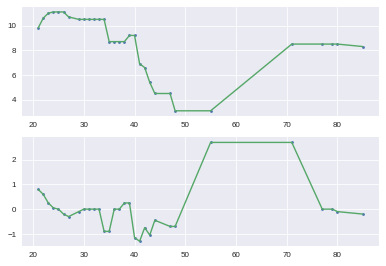

In [35]:
glonList = dataDF["glon"].tolist()
# Seaborn styling
sns.set_style("darkgrid")
sns.set_context("paper")
fig1 = plt.figure()
ax1 = fig1.add_subplot(211)
ax2 = fig1.add_subplot(212)
selDF = dataDF[ (dataDF["glon"] == -80.0) & ( dataDF["gdlat"] > 20. ) ]
latArr = selDF["gdlat"].values
tecArr = selDF["tec"].values
medTecArr = signal.medfilt( tecArr, kernel_size=5 )
diffTecArr = numpy.gradient(medTecArr)
# selDF.plot( x="gdlat", y="tec", ax=ax )
# selDF.plot( x="gdlat", y="tec", ax=ax, kind="scatter" )
ax1.plot( latArr, medTecArr, "." )
ax1.plot( latArr, medTecArr, "-" )

ax2.plot( latArr, diffTecArr, "." )
ax2.plot( latArr, diffTecArr, "-" )

In [8]:
print tecArr
diffTec = numpy.gradient(tecArr)
print "----------------"
print diffTec

[  9.9  10.2  10.1   9.8  10.5  10.9  12.2  12.7  10.5  11.   10.5  13.2
  12.4  11.2  10.    8.4   8.    9.8  11.1  12.    4.7   5.6   3.2   2.9
   4.9   5.6   4.4   6.9   6.8   7.5]
----------------
[ 0.3   0.1  -0.2   0.2   0.55  0.85  0.9  -0.85 -0.85  0.    1.1   0.95
 -1.   -1.2  -1.4  -1.    0.7   1.55  1.1  -3.2  -3.2  -0.75 -1.35  0.85
  1.35 -0.25  0.65  1.2   0.3   0.7 ]
